# Support Vector Machine

# Load the library

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn import metrics
from sklearn.utils import resample 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

# Dataset Overview

The dataset I want to use is **[Credit Card Default](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)** from **[UCI Machine Learning Repository](https://archive.ics.uci.edu/)**

Now let's load the dataset into our environment

In [146]:
df = pd.read_csv('default of credit card clients.csv', header = 1)

In [147]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


We can see that this dataset contain several columns:
- **ID**: ID that are randomly assigned
- **limit_bal**: credit limit
- **sex**: gender
- **education**: level of education
- **marriage**: marital status
- **age**
- **pay_**: when the last 6 bills was paid
- **bll_amt**: what the last 6 bills were
- **pay_amt**: how much the last payment were
- **default payment next month**

We see that **ID** column is not necessary and the column **default payment next month** is too long  
Now we drop the **ID** column and rename the **defauft payment next month** column

In [150]:
df.rename({'default payment next month': 'DEFAULT'}, axis = 'columns', inplace = True)
# df = df.drop('ID', axis=1, inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Missing data

## Identify missing data

In [153]:
df.dtypes

ID           int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

Now I want to check for unappopriate value in some column 

In [155]:
df['SEX'].unique()

array([2, 1], dtype=int64)

In [156]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

Now there is a problem there since this contain 0, 5, 6 is not mentioned in the dataset descrtiption

There should be a case when 0 represent missing data

In [159]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0], dtype=int64)

Also here 0 could represent missing data

## Dealing with missing data

In [162]:
len(df.loc[
    (df['EDUCATION'] == 0) 
    | 
    (df['MARRIAGE'] == 0)
    ]
   )

68

In [163]:
len(df)

30000

So we can see that there are only **68/30000** rows with missing data, so we can remove them without affecting the model prediction too much (Note that I consider 0 as missing data here)

In [165]:
df_no_missing = df.loc[
    (df['EDUCATION'] != 0) 
    & 
    (df['MARRIAGE'] != 0)
    ]

In [166]:
len(df_no_missing)

29932

# EDA (Exploratory data analysis)

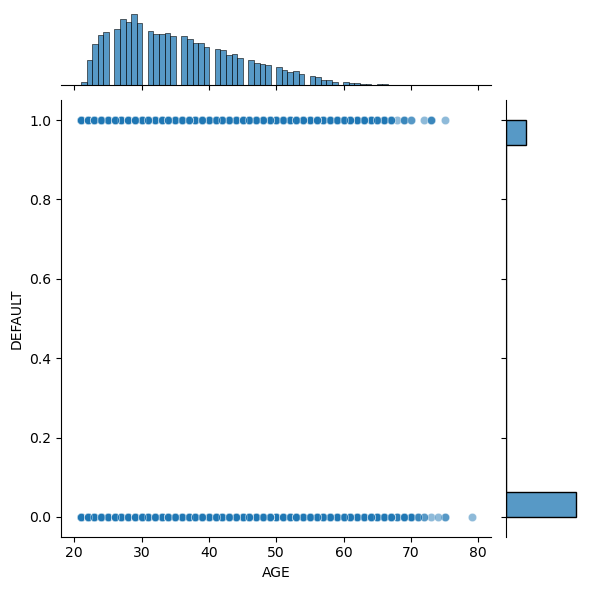

In [168]:
df_no_missing = pd.DataFrame(df_no_missing)
%matplotlib inline
sns.jointplot(x = "AGE", y = "DEFAULT", data=df_no_missing, alpha=0.5)
plt.show()

# Downsample the data

**Support Vector Machine** works better with a smaller amount of data  
So we will downsample the data to **1000 samples** for better classification

In [171]:
df_no_missing

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [172]:
df_no_default = df_no_missing[df_no_missing['DEFAULT'] == 0]
df_default = df_no_missing[df_no_missing['DEFAULT'] == 1]

In [173]:
df_no_default_downsampled = resample(df_no_default,
                                    replace = False,
                                    n_samples = 1000,
                                    random_state = 42)

In [174]:
df_default_downsampled = resample(df_default,
                                    replace = False,
                                    n_samples = 1000,
                                    random_state = 42)

In [175]:
df_downsampled = pd.concat([df_no_default_downsampled, df_default_downsampled])

In [176]:
len(df_downsampled)

2000

# Format data 

## Split the data into dependent and independent variables

In [179]:
X = df_downsampled.drop('DEFAULT', axis = 1).copy()
X.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,642,130000,2,3,1,28,0,0,0,0,...,50000,0,0,0,2500,1000,0,0,0,0
4678,4679,170000,1,3,1,29,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,16005,180000,2,2,1,29,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,22975,210000,2,2,2,32,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,17536,190000,2,3,1,45,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [180]:
y = df_downsampled['DEFAULT'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

## One Hot Encoding

In [182]:
X_encoded = pd.get_dummies(X, columns = ['SEX',
                                          'EDUCATION',
                                          'MARRIAGE',
                                          'PAY_0',
                                          'PAY_2',
                                          'PAY_3',
                                          'PAY_4',
                                          'PAY_5',
                                          'PAY_6'
                                         ]
                           )                 

In [183]:
X_encoded.head()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,642,130000,28,100143,50456,50000,0,0,0,2500,...,False,True,False,False,False,False,False,False,False,False
4678,4679,170000,29,165027,168990,172307,35234,32869,33862,7200,...,False,False,False,True,False,False,False,False,False,False
16004,16005,180000,29,25781,26000,26310,26662,26166,26176,1800,...,False,False,False,True,False,False,False,False,False,False
22974,22975,210000,32,355,975,410,0,0,0,979,...,False,True,False,False,False,False,False,False,False,False
17535,17536,190000,45,76433,78472,80548,81778,83082,84811,3300,...,False,False,False,True,False,False,False,False,False,False


## Train test and scale the data

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42)

In [186]:
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

# Build a preliminary Support Vector Machine

In [188]:
clf_svm = SVC(random_state = 42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

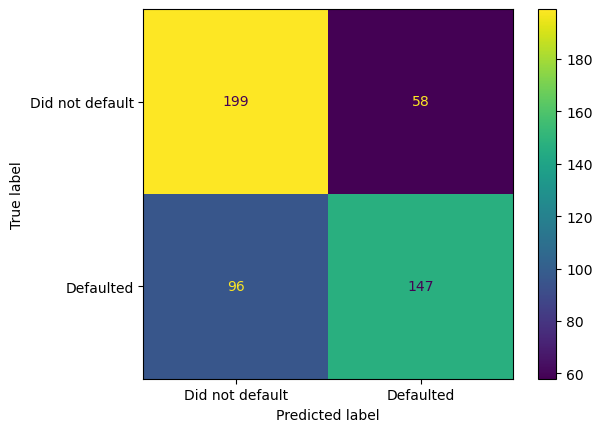

In [189]:
# Draw confusion matrix
y_pred = clf_svm.predict(X_test_scaled)

# Create confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did not default", "Defaulted"])
disp.plot()
plt.show()

In the confusion matrix, we can see out of **257** people that did not default, the SVM correctly classify **199 (77.43%)**   
and out of **243** people that defaulted, the SVM correctly classify **147 (60.49%)** of the sample

But we can optimize it even futher

# Optimize parameter

In [193]:
param_grid = [
    {'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]

In [194]:
optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
    verbose = 0
)

In [195]:
optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


We found out that the best value for C is **100**, for gamma is **0.001**

# Build the final Support Vector Machine

In [198]:
clf_svm2 = SVC(random_state = 42, C = 100, gamma = 0.001)
clf_svm2.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

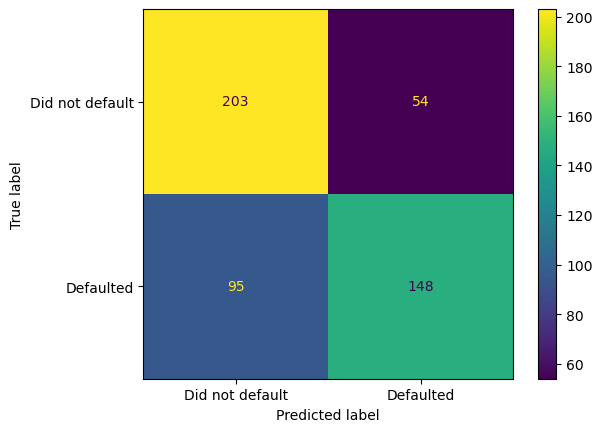

In [199]:
# Draw confusion matrix
y_pred2 = clf_svm2.predict(X_test_scaled)

# Create confusion matrix
cm2 = metrics.confusion_matrix(y_test, y_pred2)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["Did not default", "Defaulted"])
disp.plot()
plt.show()

With some optimization now we get a slightly better result, not much I would say as there are **4** more people correctly classified as did not default and **1** more for defaulted

# PCA (Principle Component Analysis)

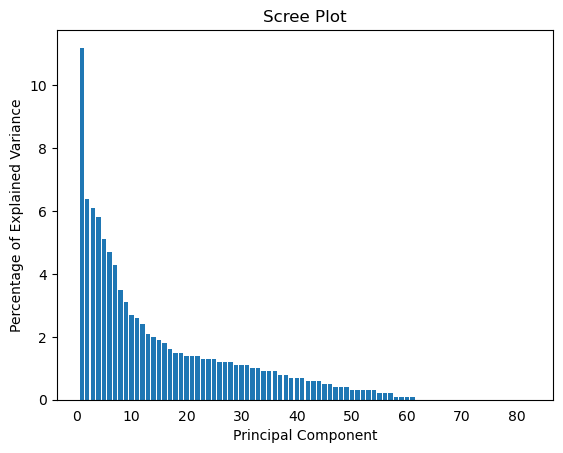

In [202]:
pca = PCA()  
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',  
    which='both',
    bottom=False,  
    top=False 
)
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.title('Scree Plot')
plt.show()

The first column is great at predicting  
However, the second column is not much better than the other column at predicting

We will call it **PC1** and **PC2**

# Draw a Support Vector Machine from PC1 and PC2

## Identify the best parameters

In [207]:
train_pc1_coords = X_train_pca[:, 0]  
train_pc2_coords = X_train_pca[:, 1] 

# Center and scale the PCs
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

# Define the parameters for the SVM model
param_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
}

# Perform grid search to find the best hyperparameters
optimal_params = GridSearchCV(
    SVC(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', 
)
optimal_params.fit(pca_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


## Drawing the graph

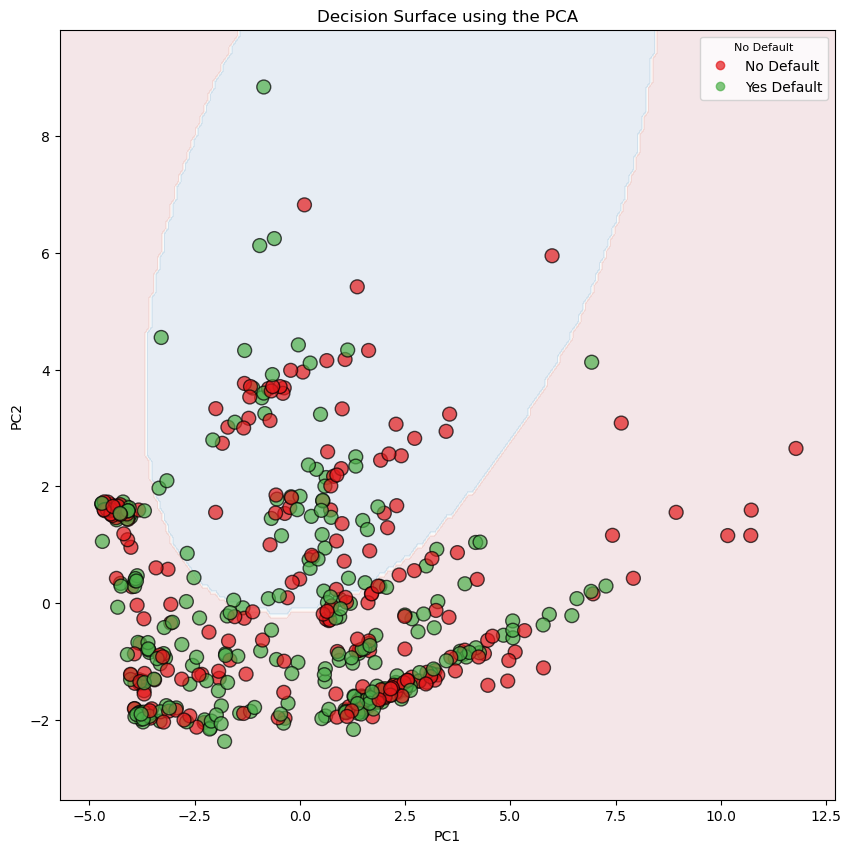

In [213]:
clf_svm = SVC(random_state=42, C=1000, gamma=0.001)
clf_svm.fit(pca_train_scaled, y_train)

X_test_pca = pca.transform(X_test_scaled)
test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]

x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1
y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                    np.arange(start=y_min, stop=y_max, step=0.1))

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10, 10))

ax.contourf(xx, yy, Z, alpha=0.1, cmap='RdBu')

cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train[:len(test_pc1_coords)], cmap=cmap, s=100, edgecolors='k', alpha=0.7)

# Create a legend
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="No Default", title_fontsize=8)
legend.get_texts()[0].set_text("No Default")
legend.get_texts()[1].set_text("Yes Default")

# Add axis labels and titles
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Decision Surface using the PCA')
plt.show()

It's expectable that the model look like a mess since the 2 vairables drawed on the graph not explain much of the variance 

But still the model is good enough to predict accuracy of probability of default among six data mining methods